In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('../src/')

In [3]:
from multiprocessing import Pool
from pathlib import Path
import string
import tempfile

import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from processing.char_detection import CharDetector
from processing.plate_detection import PlateDetector

In [4]:
CASCADE_DIR_PATH = Path('../cascades')
CHOSEN_CASCADE = CASCADE_DIR_PATH / 'haarcascade_russian_plate_number.xml'

DATA_DIR = Path('../data/real')

BASE_MIN_NEIGHBOURS = 5
MIN_BLOBS = 5

plt.set_cmap('gray')


<Figure size 432x288 with 0 Axes>

In [5]:
def display_characters(chars):
    fig, axs = plt.subplots(1, len(chars))
    for i, letter in enumerate(chars):
        axs[i].imshow(letter)

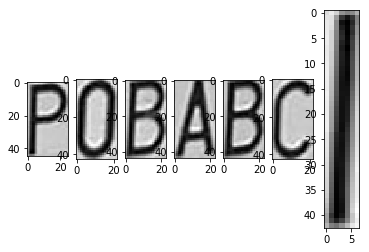

In [6]:
def get_characters(img_path, display=True):
    plate_detector = PlateDetector(str(CHOSEN_CASCADE), BASE_MIN_NEIGHBOURS)
    char_detector = CharDetector()

    regions, coords = plate_detector.detect(str(img_path))

    with Pool() as pool:
        regions_chars = pool.map(char_detector.get_characters, regions)

    for n, (region, chars, (x, y, w, h)) in enumerate(
            zip(regions, regions_chars, coords)
    ):
        if len(chars) > MIN_BLOBS:
            if display:
                display_characters(chars)
            return chars
    return []
                        
characters = get_characters(DATA_DIR / 'POBABCI.jpg')

In [7]:
def get_backround_color(char):
    return int(np.median(char[char > 100]))

In [8]:
def pad_image(img, desired_size):
    im = Image.fromarray(img)
    old_size = im.size

    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    im = im.resize(new_size, Image.ANTIALIAS)
    
    bg_color = get_backround_color(img)
    padded_im = Image.new("L", (desired_size, desired_size), color=bg_color)
    
    padded_im.paste(im, ((desired_size-new_size[0]) // 2,
                        (desired_size-new_size[1]) // 2))
    return padded_im

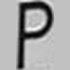

In [9]:
pad_image(characters[0], 70)

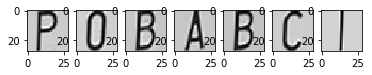

In [10]:
target_size = 28

padded_chars = [np.array(pad_image(c, target_size)) for c in characters]
display_characters(padded_chars)

In [11]:
chars_avaible = string.ascii_uppercase + string.digits
chars_avaible = chars_avaible.replace('Q', '')
chars_avaible

'ABCDEFGHIJKLMNOPRSTUVWXYZ0123456789'

In [12]:
CHAR_TAGET_DIR = Path('../data/char_train/')

for c in chars_avaible:
    (CHAR_TAGET_DIR / c).mkdir(exist_ok=True)
    

In [13]:
TARGET_SIZE = 28

for plate_img_path in DATA_DIR.glob("*.jpg"):
    plate_name = plate_img_path.name[:-4]
    print(plate_name)
    
    characters = get_characters(plate_img_path, display=False)
    
    for char, char_img in zip(plate_name, characters):
        padded_im = pad_image(char_img, TARGET_SIZE)
        
        file_name = tempfile.NamedTemporaryFile(prefix=f'{char}_', suffix='.png', 
                                        mode='w+b', dir=CHAR_TAGET_DIR / char, delete=False)
        padded_im.save(file_name)

WX88000
POBABCI
POJAJA
DOBUZI
SMB9001


In [14]:
df = pd.read_json('../data/platesmania_data/platesmania.json')
df.text = df.text.str.replace(' ', '')
df.head()

full_img_file  \
0  2db1f8de74e52dd948244ddb526752c64cbf134c.jpg   
1  826307bccc0f7d9205a7ba3c52a63399c005a582.jpg   
2  d45deb7eb7e1af1d5adf01d1f9c1ecf8477e30d8.jpg   
3  ea76ccf486ec4d04b5f1d0622400c90affca88cd.jpg   
4  17984be6f202bf586704b63966cedb6033d82ab9.jpg   

                                 plate_img_file      text  
0  7f39adae9234cddf550dfc3f7a8956b6172891b1.jpg     SBE8X  
1  f0b3ff1629d24086bc4166e1a1869ad891c74bf8.jpg   WE086EN  
2  023e49296c2f5570d4cb073551a958e9d45d80b6.jpg   BI5984Y  
3  e05e99e04e81ec95e876246a62b66de1373dfd8d.jpg   SNE8108  
4  ba8a81053a00f5e3854601a05a6b03d9f9f1693a.jpg  WGM40927

In [15]:
PLATESMANIA_DATA_DIR = Path('../data/platesmania_data/plate_images/full/')

for file, plate_name in zip(df.full_img_file, df.text):
    plate_img_path = PLATESMANIA_DATA_DIR / file
    
    try:
        characters = get_characters(plate_img_path, display=False)
    
        if len(characters) == len(plate_name):
            print(plate_name, "OK...")

            for char, char_img in zip(plate_name, characters):
                padded_im = pad_image(char_img, TARGET_SIZE)

                file_name = tempfile.NamedTemporaryFile(prefix=f'{char}_', suffix='.png', 
                                                mode='w+b', dir=CHAR_TAGET_DIR / char, delete=False)
                padded_im.save(file_name)  
        else:
            print(plate_name, "Characters not found...")
    except:
        continue

SBE8X Characters not found...
WE086EN Characters not found...
BI5984Y Characters not found...
SNE8108 OK...
WGM40927 OK...
DW9798Y Characters not found...
SK342NV OK...
LRY2L52 OK...
ZSD29259 Characters not found...
DW4T118 Characters not found...
WF6669M OK...
KTT9M66 Characters not found...
LLU33RV Characters not found...
RLU40EW OK...
TK1788T OK...
WAB0835 Characters not found...
FSWCP14 OK...
PCT40620 Characters not found...
PO5F856 Characters not found...
DWLAG09 OK...
PO5S920 Characters not found...
G0DANA5 OK...
WZ5899R Characters not found...
RMI79296 Characters not found...
WFO946L Characters not found...
SCI82912 Characters not found...
WOTPP09 Characters not found...
KBC35877 OK...
TKIFJ80 Characters not found...
PL93909 Characters not found...
W04186 Characters not found...
SMI8N94 Characters not found...
LB67042 Characters not found...
KR7U903 OK...
WIC8190 Characters not found...
OST20FP Characters not found...
WGM40353 Characters not found...
RP67183 Characters not found

/usr/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LJA01921 OK...
DBL36G4 Characters not found...
KR4U154 Characters not found...
DZA91KV Characters not found...
KN52193 OK...
WZW21870 Characters not found...
WW7017G Characters not found...
KR753WG Characters not found...
WSE44Y5 Characters not found...
SBE0100A Characters not found...
LSW34255 OK...
ZS695AS Characters not found...
GD768KE Characters not found...
KR8CR08 Characters not found...
KR7Y153 Characters not found...
FZI69492 OK...
PGO28676 Characters not found...
DWR4664E OK...
WSZ76FU Characters not found...
BIA32537 Characters not found...
LBI16155 OK...
WE173UF Characters not found...
TOS44577 Characters not found...
LLU09594 Characters not found...
ZK74624 Characters not found...
SZ22490 Characters not found...
RP73347 OK...
ZS129JH OK...
KR474LA Characters not found...
SG4514 OK...
POS2P37 Characters not found...
LUB11939 Characters not found...
KWAWP63 Characters not found...
WZU76NP Characters not found...
CBY50338 Characters not found...
DLE11024 OK...
L02330 OK...
DW

W04186 Characters not found...
RP76475 OK...
DKLEK57 OK...
GSP50HF Characters not found...
LLU68596 Characters not found...
RJA67462 Characters not found...
NOZ0617 Characters not found...
CTU24WA Characters not found...
LC47536 Characters not found...
LLU10440 Characters not found...
BKP161X Characters not found...
KRA4940H Characters not found...
KTT7E86 Characters not found...
WSI00671 OK...
FNW43509 OK...
GS26524 Characters not found...
LZA50153 Characters not found...
RZEHK51 Characters not found...
WOR43225 Characters not found...
KR3R469 OK...
SMI6WC3 Characters not found...
GS07955 Characters not found...
SCI66606 OK...
DW5M817 Characters not found...
PO9AV13 Characters not found...
WU1375G Characters not found...
WP79 Characters not found...
WW363XR OK...
REF2857 Characters not found...
LZA54419 Characters not found...
KBC17228 Characters not found...
K0KAMA Characters not found...
WE0107R Characters not found...
D1STONE OK...
WJ1419G OK...
LZ42909 Characters not found...
WWL7

WKZAN11 Characters not found...
ZPY58NR Characters not found...
DSTY984 Characters not found...
KT1475A Characters not found...
EL006JN Characters not found...
KR1M502 Characters not found...
POB65RL Characters not found...
DW739RF OK...
RJA41334 OK...
PO7GU94 Characters not found...
RJA51024 Characters not found...
WR6372S Characters not found...
DW1W387 Characters not found...
KSU21FX Characters not found...
GD861MN Characters not found...
SD45214 Characters not found...
DW62116 OK...
WKZ04UH Characters not found...
SMI4US3 Characters not found...
WSI73K9 Characters not found...
ST6009L Characters not found...
WGM38874 OK...
ERW6J37 OK...
GD143SE OK...
ST0330N Characters not found...
SR3890G OK...
KTT2S30 Characters not found...
WE00746 OK...
GS01453 Characters not found...
SM96912 OK...
RP75423 OK...
WO58761 OK...
WE135JW Characters not found...
GD20290 Characters not found...
NDZ23471 OK...
KBR87FR Characters not found...
KOS90709 Characters not found...
WZZ393B Characters not foun